In [16]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score, classification_report

In [17]:
# Load DataFrame
df = pd.read_csv('FS_data.csv')

In [18]:
# Display DataFrame
df

,Mouth_Open_mean,Mouth_Open_std,Mouth_Open_skew,Mouth_Open_median,Mouth_Open_range,Mouth_Closed_mean,Mouth_Closed_std,Mouth_Closed_skew,Mouth_Closed_median,Mouth_Closed_range,...,Right Eyebrow_Raised_skew,Right Eyebrow_Raised_median,Right Eyebrow_Raised_range,Right Eyebrow_Lowered_mean,Right Eyebrow_Lowered_std,Right Eyebrow_Lowered_skew,Right Eyebrow_Lowered_median,Right Eyebrow_Lowered_range,Artificiality,Expressiveness
0,0.001626,0.040292,24.740678,0.0,1,0.998374,0.040292,-24.740678,1.0,1,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
1,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
2,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
3,0.000055,0.007412,134.914788,0.0,1,0.999945,0.007412,-134.914788,1.0,1,...,0.0,0.0,0,0.370454,0.48294,0.536549,0.0,1,2,1
4,0.001260,0.035469,28.125509,0.0,1,0.998740,0.035469,-28.125509,1.0,1,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.008999,0.094439,10.399382,0.0,1,0.991001,0.094439,-10.399382,1.0,1,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2
76,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2
77,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2
78,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2


In [19]:
# Extract features by dropping target columns from the DataFrame
X = df.drop(['Expressiveness','Artificiality'], axis=1)  
# Extract target variable 'Artificiality' from the DataFrame
y = df['Artificiality'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Initialize the pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=LogisticRegression(penalty='l2', random_state=42), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', LogisticRegression(penalty='l2', random_state=42, max_iter=1000))
])

# Define the parameter grid
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'feature_selector__estimator__C': [0.01, 0.1, 1]
}

# Create inner and outer CV
outer_cv_lr = StratifiedKFold(n_splits=5)
inner_cv_lr = StratifiedKFold(n_splits=10)

# Create the Grid Search estimator
clf_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=inner_cv_lr, scoring='f1', n_jobs=-1)

# Calculate the generalization error using F1
nested_score_lr = cross_val_score(clf_lr, X=X_train, y=y_train, cv=outer_cv_lr, scoring='f1')
print(
    "The mean score using nested cross-validation is: "
    f"{nested_score_lr.mean():.3f} ± {nested_score_lr.std():.3f}"
)

# Fit Grid Search estimator to find best hyperparameters
clf_lr.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams = clf_lr.best_params_
print("Best hyperparameters:", best_hyperparams)

# Create new pipeline with the best hyperparameters
final_pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=LogisticRegression(penalty='l2', random_state=42, C=best_hyperparams['feature_selector__estimator__C']), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', LogisticRegression(penalty='l2', random_state=42, max_iter=1000, C=best_hyperparams['classifier__C']))
])

# Train the final model on the entire training set
final_pipeline_lr.fit(X_train, y_train)

# Make predictions using the final estimator
y_train_pred_lr = final_pipeline_lr.predict(X_train)
y_test_pred_lr = final_pipeline_lr.predict(X_test)

# Evaluation using the final estimator
f1_train_lr = f1_score(y_train, y_train_pred_lr, average='macro')
f1_test_lr = f1_score(y_test, y_test_pred_lr, average='macro')

# Output final F1 scores
print(f"F1 Score on training data: {f1_train_lr}")
print(f"F1 Score on test data: {f1_test_lr}")

# Output classification reports
print("Classification Report for Training Data (LR):")
print(classification_report(y_train, y_train_pred_lr))
print("Classification Report for Test Data (LR):")
print(classification_report(y_test, y_test_pred_lr))

The mean score using nested cross-validation is: 0.555 ± 0.115
Best hyperparameters: {'classifier__C': 0.1, 'feature_selector__estimator__C': 0.1}
F1 Score on training data: 0.6652552926525529
F1 Score on test data: 0.5465587044534412
Classification Report for Training Data (LR):
              precision    recall  f1-score   support

           1       0.63      0.81      0.71        32
           2       0.74      0.53      0.62        32

    accuracy                           0.67        64
   macro avg       0.69      0.67      0.67        64
weighted avg       0.69      0.67      0.67        64

Classification Report for Test Data (LR):
              precision    recall  f1-score   support

           1       0.55      0.75      0.63         8
           2       0.60      0.38      0.46         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16



Number of features selected by RFECV: 4
                    Feature  Coefficient
2   Right Eye_Closed_median    -0.332710
3  Left Eyebrow_Raised_mean     0.270464
0        Right Eye_Open_std     0.202863
1      Right Eye_Closed_std     0.202863


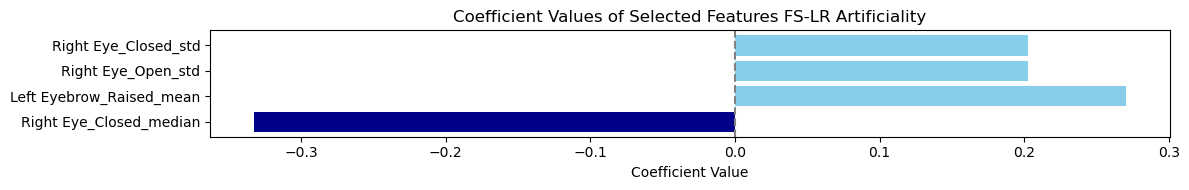

In [21]:
# Extract feature names
feature_names = X_train.columns

# Extract the boolean mask of selected features from RFECV
selected_features_mask_lr = final_pipeline_lr.named_steps['feature_selector'].support_

# Get the list of selected feature names
selected_feature_names_lr = feature_names[selected_features_mask_lr]

# Extract the coefficients from the LR model
coefficients_lr = final_pipeline_lr.named_steps['classifier'].coef_.flatten()

# Create a DataFrame to display the features and their coefficients
features_coefficients_df_lr = pd.DataFrame({
    'Feature': selected_feature_names_lr,
    'Coefficient': coefficients_lr
})

# Sort the DataFrame by the absolute values of the coefficients
features_coefficients_df_lr = features_coefficients_df_lr.reindex(
    features_coefficients_df_lr.Coefficient.abs().sort_values(ascending=False).index
)

# Printing the number of features selected and the DataFrame
n_features_selected_lr = sum(selected_features_mask_lr)
print("Number of features selected by RFECV:", n_features_selected_lr)
print(features_coefficients_df_lr)

# Save the DataFrame to a CSV file
features_coefficients_df_lr.to_csv('FS_Artificiality_Feature_Coefficients_LR.csv', index=False)

# Define colors based on the sign of the coefficients
colors = ['darkblue' if x < 0 else 'skyblue' for x in features_coefficients_df_lr['Coefficient']]

# Plotting the coefficients with the specified colors
plt.figure(figsize=(12, 2))
plt.barh(
    range(len(features_coefficients_df_lr)),
    features_coefficients_df_lr['Coefficient'],
    color=colors
)
plt.yticks(
    range(len(features_coefficients_df_lr)),
    features_coefficients_df_lr['Feature']
)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values of Selected Features FS-LR Artificiality')
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

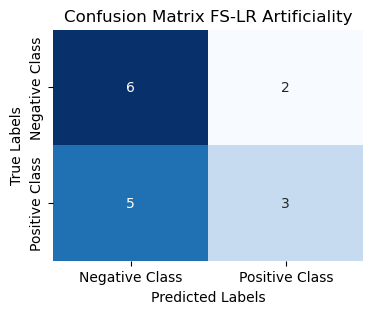

In [22]:
# Calculate the confusion matrix for the test data
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FS-LR Artificiality')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'], va='center')
plt.show()

In [23]:
# Initialize the pipeline
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=SVC(kernel='linear', random_state=42), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Define the parameter grid
param_grid_svc = {
    'classifier__C': [0.01, 0.1, 1],
    'feature_selector__estimator__C': [0.1, 1, 10]
}

# Create inner and outer CV
outer_cv_svc = StratifiedKFold(n_splits=5)
inner_cv_svc = StratifiedKFold(n_splits=10)

# Create the Grid Search estimator
clf_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=inner_cv_svc, scoring='f1', n_jobs=-1)

# Calculate the generalization error using F1
nested_score_svc = cross_val_score(clf_svc, X=X_train, y=y_train, cv=outer_cv_svc, scoring='f1')
print(
    "The mean score using nested cross-validation for SVC is: "
    f"{nested_score_svc.mean():.3f} ± {nested_score_svc.std():.3f}"
)

# Fit Grid Search estimator to find best hyperparameters
clf_svc.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams_svc = clf_svc.best_params_
print("Best hyperparameters for SVC:", best_hyperparams_svc)

# Create a new pipeline with the best hyperparameters
final_pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=SVC(kernel='linear', random_state=42, C=best_hyperparams_svc['feature_selector__estimator__C']), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', SVC(kernel='linear', random_state=42, C=best_hyperparams_svc['classifier__C']))
])

# Train the final model on the entire training set
final_pipeline_svc.fit(X_train, y_train)

# Make predictions using the final estimator
y_train_pred_svc = final_pipeline_svc.predict(X_train)
y_test_pred_svc = final_pipeline_svc.predict(X_test)

# Evaluation using the final estimator
f1_train_svc = f1_score(y_train, y_train_pred_svc, average='macro')
f1_test_svc = f1_score(y_test, y_test_pred_svc, average='macro')

# Output final F1 scores
print(f"F1 Score on training data (SVC): {f1_train_svc}")
print(f"F1 Score on test data (SVC): {f1_test_svc}")

# Output classification reports
print("Classification Report for Training Data (SVC):")
print(classification_report(y_train, y_train_pred_svc))
print("Classification Report for Test Data (SVC):")
print(classification_report(y_test, y_test_pred_svc))

The mean score using nested cross-validation for SVC is: 0.529 ± 0.060
Best hyperparameters for SVC: {'classifier__C': 0.1, 'feature_selector__estimator__C': 1}
F1 Score on training data (SVC): 0.6679021497405486
F1 Score on test data (SVC): 0.6000000000000001
Classification Report for Training Data (SVC):
              precision    recall  f1-score   support

           1       0.64      0.78      0.70        32
           2       0.72      0.56      0.63        32

    accuracy                           0.67        64
   macro avg       0.68      0.67      0.67        64
weighted avg       0.68      0.67      0.67        64

Classification Report for Test Data (SVC):
              precision    recall  f1-score   support

           1       0.58      0.88      0.70         8
           2       0.75      0.38      0.50         8

    accuracy                           0.62        16
   macro avg       0.67      0.62      0.60        16
weighted avg       0.67      0.62      0.60       

Number of features selected by RFECV: 5
                    Feature  Coefficient
0        Left Eye_Open_mean     0.463968
1        Right Eye_Open_std     0.452363
2      Right Eye_Closed_std     0.452363
3  Left Eyebrow_Raised_mean     0.256011
4   Left Eyebrow_Raised_std     0.154583


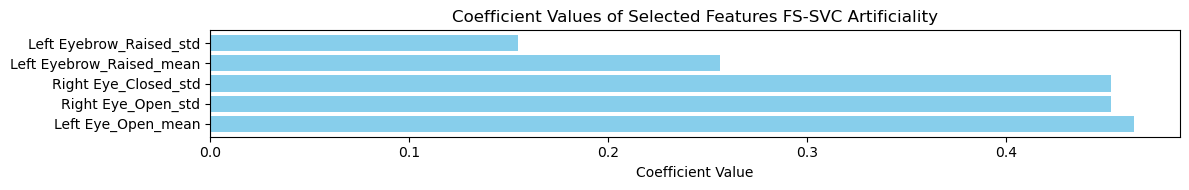

In [24]:
# Extract feature names
feature_names = X_train.columns

# Extract the boolean mask of selected features from RFECV
selected_features_mask_svc = final_pipeline_svc.named_steps['feature_selector'].support_

# Get the list of selected feature names
selected_feature_names_svc = feature_names[selected_features_mask_svc]

# Extract the coefficients from the SVC model
coefficients_svc = final_pipeline_svc.named_steps['classifier'].coef_.flatten()

# Create a DataFrame to display the features and their coefficients
features_coefficients_df_svc = pd.DataFrame({
    'Feature': selected_feature_names_svc,
    'Coefficient': coefficients_svc
})

# Sort the DataFrame by the absolute values of the coefficients
features_coefficients_df_svc = features_coefficients_df_svc.reindex(
    features_coefficients_df_svc.Coefficient.abs().sort_values(ascending=False).index
)

# Printing the number of features selected and the DataFrame
n_features_selected_svc = sum(selected_features_mask_svc)
print("Number of features selected by RFECV:", n_features_selected_svc)
print(features_coefficients_df_svc)

# Save the DataFrame to a CSV file
features_coefficients_df_svc.to_csv('FS_Artificiality_Feature_Coefficients_SVC.csv', index=False)

# Define colors based on the sign of the coefficients
colors_svc = ['darkblue' if x < 0 else 'skyblue' for x in features_coefficients_df_svc['Coefficient']]

# Plotting the coefficients with the specified colors
plt.figure(figsize=(12, 2))
plt.barh(
    range(len(features_coefficients_df_svc)),
    features_coefficients_df_svc['Coefficient'],
    color=colors_svc
)
plt.yticks(
    range(len(features_coefficients_df_svc)),
    features_coefficients_df_svc['Feature']
)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values of Selected Features FS-SVC Artificiality')
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

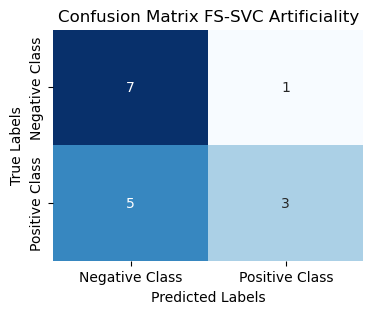

In [25]:
# Calculate the confusion matrix for the test data
cm_svc = confusion_matrix(y_test, y_test_pred_svc)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_svc, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FS-SVC Artificiality')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'], va='center')
plt.show()